# Performance Overview

Here, we will example the performance of PANDA as a function of time on several datasets. These investigations were performed on a 4 core machine (4 threads) with a 4.0 GhZ processor.


In [1]:
%%script false

## disklog.sh
#!/bin/bash -e
# run this in the background with nohup ./disklog.sh > disk.txt &
#
while true; do
    echo "$(du -s $1 | awk '{print $1}')"
    sleep 30
done


##cpulog.sh 
import psutil
import time
import argparse

def cpulog(outfile):
    with open(outfile, 'w') as outf:
        while(True):
            cores = psutil.cpu_percent(percpu=True)
            corestr = ",".join([str(core) for core in cores])
            outf.write(corestr + '\n')
            outf.flush()
            time.sleep(1)  # delay for 1 second

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('outfile', help='the file to write core usage to.')
    args = parser.parse_args()
    cpulog(args.outfile)

if __name__ == "__main__":
    main()

    
## memlog.sh
#!/bin/bash -e
# run this in the background with nohup ./memlog.sh > mem.txt &
#
while true; do
    echo "$(free -m | grep buffers/cache | awk '{print $3}')"
    sleep 1
done


## runonesub.sh
# A function for generating memory and cpu summaries for fngs pipeline.
#
# Usage: ./generate_statistics.sh /path/to/rest /path/to/anat /path/to/output

rm -rf $3
mkdir $3

./memlog.sh > ${3}/mem.txt &
memkey=$!
python cpulog.py ${3}/cpu.txt &
cpukey=$!
./disklog.sh $3 > ${3}/disk.txt &
diskkey=$!

res=2mm
atlas='/FNGS_server/atlases/atlas/MNI152_T1-${res}.nii.gz'
atlas_brain='/FNGS_server/atlases/atlas/MNI152_T1-${res}_brain.nii.gz'
atlas_mask='/FNGS_server/atlases/mask/MNI152_T1-${res}_brain_mask.nii.gz'
lv_mask='/FNGS_server/atlases/mask/HarvOx_lv_thr25-${res}.nii.gz'
label='/FNGS_server/atlases/label/desikan-${res}.nii.gz'

exec 4<$1
exec 5<$2

fngs_pipeline $1 $2 $atlas $atlas_brain $atlas_mask $lv_mask $3 none $label --fmt graphml

kill $memkey $cpukey $diskkey

In [2]:
%matplotlib inline
import numpy as np
import re
import matplotlib.pyplot as plt
from IPython.display import Image, display


def memory_function(infile, dataset):
    with open(infile, 'r') as mem:
        lines = mem.readlines()

    testar = np.asarray([line.strip() for line in lines]).astype(float)/1000

    fig=plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(0, testar.shape[0]), testar - min(testar))
    ax.set_ylabel('memory usage in GB')
    ax.set_xlabel('Time (s)')
    ax.set_title(dataset + ' Memory Usage; max = %.2f GB; mean = %.2f GB' % (max(testar) - np.min(testar), np.mean(testar) - np.min(testar)))
    return fig

def cpu_function(infile, dataset):
    with open(infile, 'r') as cpuf:
        lines = cpuf.readlines()

    testar = [re.split(',',line.strip()) for line in lines][0:-1]
    
    corear = np.zeros((len(testar), len(testar[0])))
    for i in range(0, len(testar)):
        corear[i,:] = np.array([float(cpu) for cpu in testar[i]])
    
    fig=plt.figure()
    ax = fig.add_subplot(111)
    lines = [ax.plot(corear[:,i], '--', label='cpu '+ str(i), 
                     alpha=0.5)[0] for i in range(0, corear.shape[1])]
    
    total = corear.sum(axis=1)
    lines.append(ax.plot(total, label='all cores')[0])
    
    labels = [h.get_label() for h in lines]
    
    fig.legend(handles=lines, labels=labels, loc='lower right', prop={'size':6})
    ax.set_ylabel('CPU usage (%)')
    ax.set_ylim([0, max(total)+10])
    ax.set_xlabel('Time (s)')
    ax.set_title(dataset + ' Processor Usage; max = %.1f per; mean = %.1f per' % (max(total), np.mean(total)))
    return fig

def disk_function(infile, dataset):
    with open(infile, 'r') as disk:
        lines = disk.readlines()

    testar = np.asarray([line.strip() for line in lines]).astype(float)/1000000

    fig=plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(0, testar.shape[0]), testar - min(testar))
    ax.set_ylabel('Disk usage GB')
    ax.set_xlabel('Time (30 s)')
    ax.set_title(dataset + ' Disk Usage; max = %.2f GB; mean = %.2f GB' % (max(testar), np.mean(testar)))
    return fig


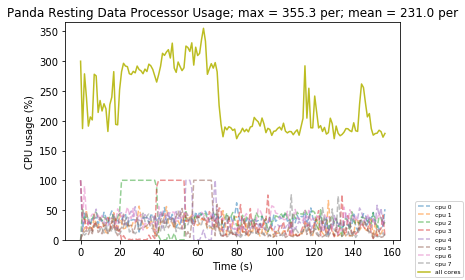

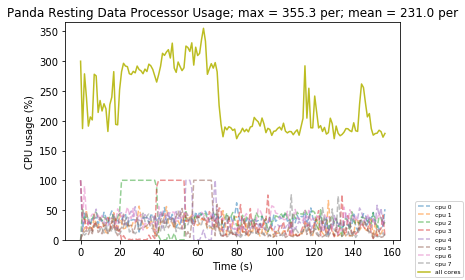

In [8]:
cpu_function("analysis_files/cpu.txt", "Panda Resting Data")

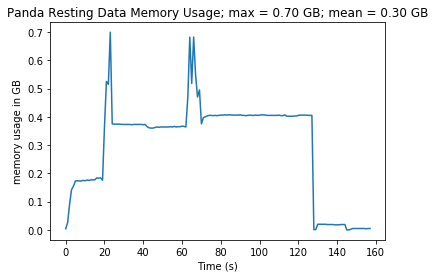

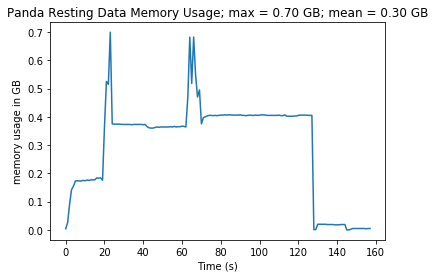

In [9]:
memory_function("analysis_files/mem.txt", "Panda Resting Data")

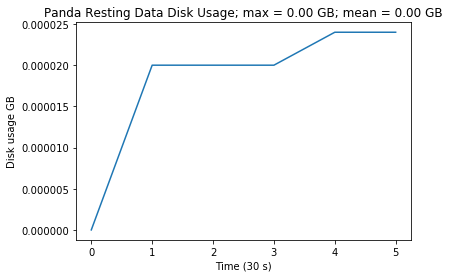

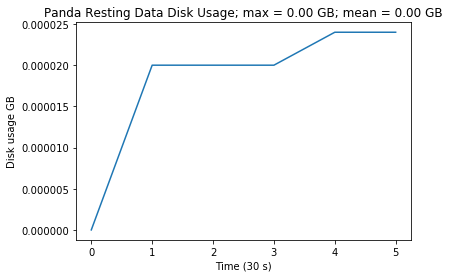

In [10]:
disk_function("analysis_files/disk.txt", "Panda Resting Data")